In [2]:
import numpy as np
import networkx as nx
import sys 
import pickle
from tqdm import tqdm
import time

sys.path.append('../../ready functions in py/')

%load_ext autoreload
%autoreload 2

from helper_fcts import *
from incremental_growth import incremental_growth_heuristic
from interpolating_prior import interpolated_prior
from angular_stress_heuristic import *
from mc_update import monte_carlo_step

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
#seeds:
#15: 15.96038676905427  6.259163707243631
#11: 15.924667642304605 6.2582664420484
#17: 15.9240 		6.2585

12

 al= 1e-05
final result, after 712 iterations.


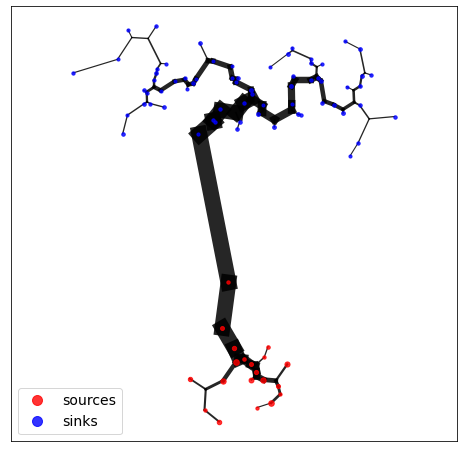

cost= 15.923964652323557

 al= 0.5
final result, after 1129 iterations.


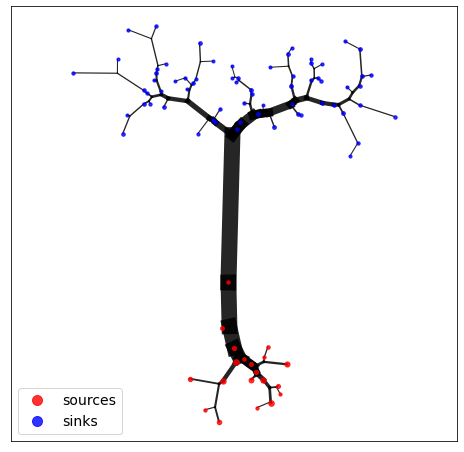

cost= 6.255332177287858

 al= 0.95
final result, after 608 iterations.


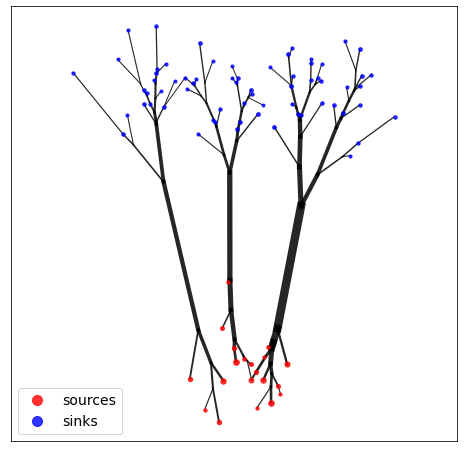

cost= 3.52903208605699

 al= 1.0


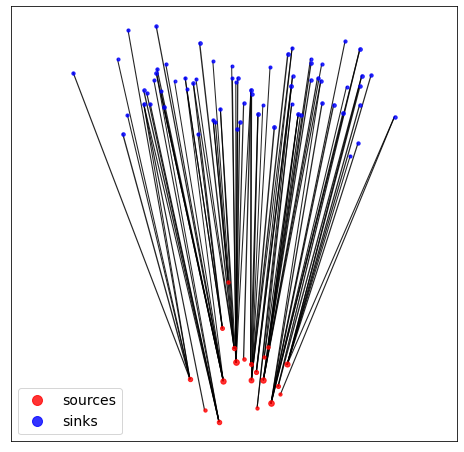

In [8]:
seed_list = [17,17,11,17,13,13,17, 17]

for seed in [12]:

    np.random.seed(seed)
    print(seed)

    #tree like experiment:
    n_sources = 20
    n_sinks = 45
    centers = np.array([
        [0,0],
        [-1,3],
        [0,3],
        [1,3]
    ])    

    coords_sources = np.random.normal(size=(n_sources, 2), scale=0.3) + centers[0]
    coords_sinks = np.vstack((np.random.normal(size=(int(n_sinks/2), 2), scale=0.3) + centers[1], 
                              np.random.normal(size=(int(n_sinks/2), 2), scale=0.3) + centers[2], 
                              np.random.normal(size=(int(n_sinks/2), 2), scale=0.3) + centers[3]))

    al_arr = np.array([0.00001, 0.5, 0.95, 1])

    bot_problem_dict = {}
    bot_problem_dict["coords_sources"] = coords_sources
    bot_problem_dict["coords_sinks"] = coords_sinks
    bot_problem_dict["supply_arr"] = np.random.random(len(coords_sources))
    bot_problem_dict["supply_arr"] /= np.sum(bot_problem_dict["supply_arr"])
    bot_problem_dict["demand_arr"] = np.random.random(len(coords_sinks))
    bot_problem_dict["demand_arr"] /= np.sum(bot_problem_dict["demand_arr"])

    supply_arr = bot_problem_dict["supply_arr"]
    demand_arr = bot_problem_dict["demand_arr"]

    for i,al in enumerate(al_arr):
        np.random.seed(seed_list[i])
        
        print("\n al=", al)
        bot_problem_dict["al"] = al    

        if al > 0.999:
            al = 1
            int_prior_topo = interpolated_prior(bot_problem_dict, beta = 1-al)
            cost, coords_real = iterative_bot_solver(int_prior_topo, supply_arr, demand_arr, coords_sources, coords_sinks, al,
                                                         relative_improvement_threshold=1e-6, min_iterations=-1, max_iterations=1000,
                                                         plot=False, title="", fov=None, save=False, save_name="img")

            coords_arr = np.vstack((coords_sources, coords_sinks))
            num_bps = nx.number_of_nodes(int_prior_topo) - len(supply_arr) -len(demand_arr)
            coords_arr = np.vstack((coords_arr, np.zeros((num_bps, 2)) ))
            for bp in int_prior_topo.nodes():
                if bp >= 0:
                    continue
                for neighbour in nx.neighbors(int_prior_topo, bp):
                    if neighbour >= 0:
                        coords_arr[bp] = np.copy(coords_arr[neighbour])

            visualise_BOT_solution(int_prior_topo, coords_arr, supply_arr, demand_arr, title="", fov=None, save=True, save_name=f"img1.0")

        else:
            beta = 1 - al
            int_prior_topo = interpolated_prior(bot_problem_dict, beta)
            stress_cost, stress_topo = angular_stress_reduction(int_prior_topo, bot_problem_dict, plot_final=False, plot=False)

            # stress heuristic with MC continued:
            topo = stress_topo.copy()
            cost, coords_iter = iterative_bot_solver(topo, supply_arr, demand_arr, coords_sources, coords_sinks, al,
                                                     relative_improvement_threshold=1e-9, min_iterations=-1,
                                                     max_iterations=10000,
                                                     plot=False, title="", fov=None, save=False, save_name="img")
            keep_going = True
            iteration = 0
            T = 0
            sample_edge_list = list(topo.edges())
            while keep_going and iteration < 60000:
                iteration += 1
                topo, sample_edge_list, cost, coords_iter, accepted = monte_carlo_step(topo, sample_edge_list, cost,
                                                                                       coords_iter, bot_problem_dict,
                                                                                       temperature=T)
                # check if converged:
                if len(sample_edge_list) == 0:
                    # this means that we have stuck with one topology for an entire run through.
                    keep_going = False

            print(f"final result, after {iteration} iterations.")

            cost, coords_iter = iterative_bot_solver(topo, supply_arr, demand_arr, coords_sources, coords_sinks, al,
                                                     relative_improvement_threshold=1e-7, min_iterations=-1,
                                                     max_iterations=2000,
                                                     plot=True, title="", fov=None, save=True, save_name=f"img{np.round(al,2)}")
            
            print("cost=", cost)


 al= 0.0001
final result, after 302 iterations.


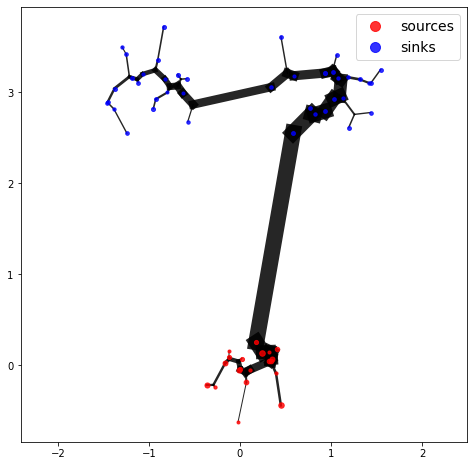


 al= 0.3
final result, after 407 iterations.


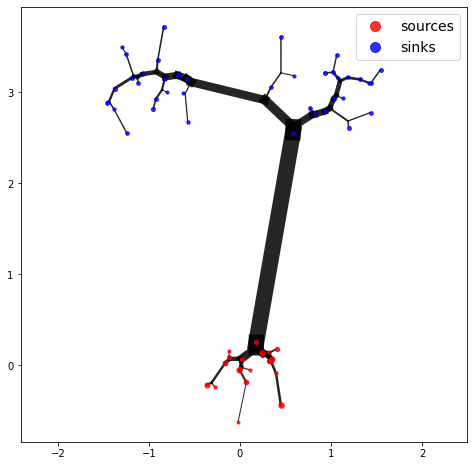


 al= 0.5
final result, after 509 iterations.


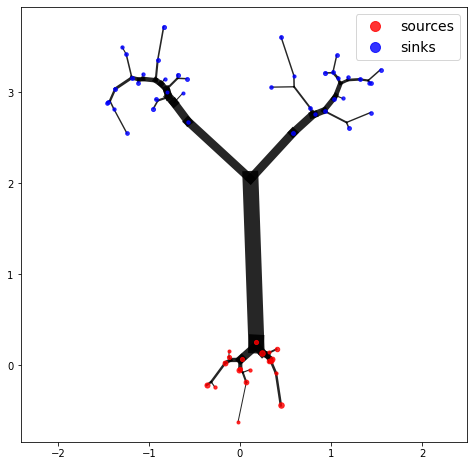


 al= 0.7
final result, after 784 iterations.


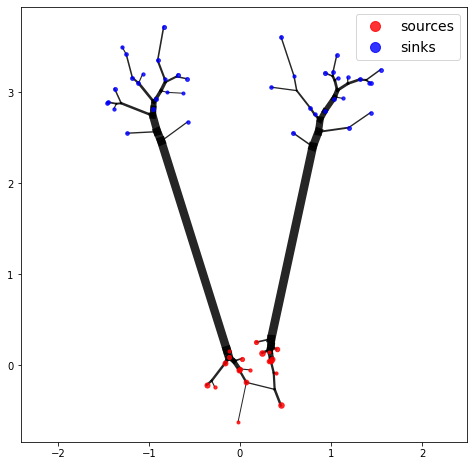


 al= 1.0


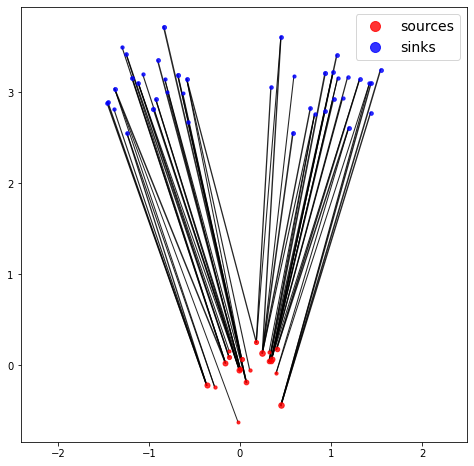

In [2]:
#1-to-2 clusters experiment:
n_sources = 20
n_sinks = 40
centers = np.array([
    [0,0],
    [-1,3],
    [1,3]
])    

coords_sources = np.random.normal(size=(n_sources, 2), scale=0.3) + centers[0]
coords_sinks = np.vstack((np.random.normal(size=(int(n_sinks/2), 2), scale=0.3) + centers[1], np.random.normal(size=(int(n_sinks/2), 2), scale=0.3) + centers[2]))

al_arr = np.array([0.0001, 0.3, 0.5, 0.7, 1])

bot_problem_dict = {}
bot_problem_dict["coords_sources"] = coords_sources
bot_problem_dict["coords_sinks"] = coords_sinks
bot_problem_dict["supply_arr"] = np.random.random(len(coords_sources))
bot_problem_dict["supply_arr"] /= np.sum(bot_problem_dict["supply_arr"])
bot_problem_dict["demand_arr"] = np.random.random(len(coords_sinks))
bot_problem_dict["demand_arr"] /= np.sum(bot_problem_dict["demand_arr"])

supply_arr = bot_problem_dict["supply_arr"]
demand_arr = bot_problem_dict["demand_arr"]

for al in al_arr:
    print("\n al=", al)
    bot_problem_dict["al"] = al    
    
    if al > 0.999:
        al = 1
        int_prior_topo = interpolated_prior(bot_problem_dict, beta = 1-al)
        cost, coords_real = iterative_bot_solver(int_prior_topo, supply_arr, demand_arr, coords_sources, coords_sinks, al,
                                                     relative_improvement_threshold=1e-6, min_iterations=-1, max_iterations=1000,
                                                     plot=False, title="", fov=None, save=False, save_name="img")

        coords_arr = np.vstack((coords_sources, coords_sinks))
        num_bps = nx.number_of_nodes(int_prior_topo) - len(supply_arr) -len(demand_arr)
        coords_arr = np.vstack((coords_arr, np.zeros((num_bps, 2)) ))
        for bp in int_prior_topo.nodes():
            if bp >= 0:
                continue
            for neighbour in nx.neighbors(int_prior_topo, bp):
                if neighbour >= 0:
                    coords_arr[bp] = np.copy(coords_arr[neighbour])

        visualise_BOT_solution(int_prior_topo, coords_arr, supply_arr, demand_arr, title="", fov=None, save=False, save_name=f"img100")
    
    else:
        beta = 1 - al
        int_prior_topo = interpolated_prior(bot_problem_dict, beta)
        stress_cost, stress_topo = angular_stress_reduction(int_prior_topo, bot_problem_dict, plot_final=False, plot=False)

        # stress heuristic with MC continued:
        topo = stress_topo.copy()
        cost, coords_iter = iterative_bot_solver(topo, supply_arr, demand_arr, coords_sources, coords_sinks, al,
                                                 relative_improvement_threshold=1e-9, min_iterations=-1,
                                                 max_iterations=10000,
                                                 plot=False, title="", fov=None, save=False, save_name="img")
        keep_going = True
        iteration = 0
        T = 0
        sample_edge_list = list(topo.edges())
        while keep_going and iteration < 60000:
            iteration += 1
            topo, sample_edge_list, cost, coords_iter, accepted = monte_carlo_step(topo, sample_edge_list, cost,
                                                                                   coords_iter, bot_problem_dict,
                                                                                   temperature=T)
            # check if converged:
            if len(sample_edge_list) == 0:
                # this means that we have stuck with one topology for an entire run through.
                keep_going = False

        print(f"final result, after {iteration} iterations.")

        cost, coords_iter = iterative_bot_solver(topo, supply_arr, demand_arr, coords_sources, coords_sinks, al,
                                                 relative_improvement_threshold=1e-6, min_iterations=-1,
                                                 max_iterations=2000,
                                                 plot=True, title="", fov=None, save=False, save_name="img")


 al= 0.0001
final result, after 117 iterations.


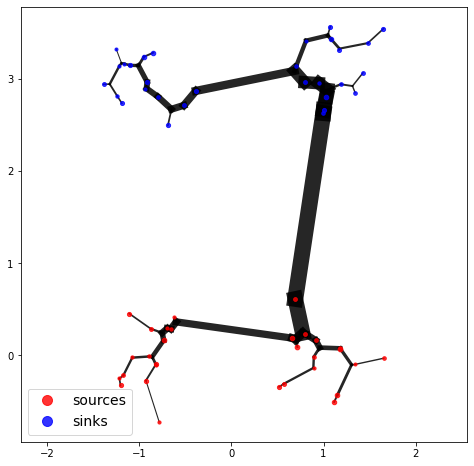


 al= 0.3
final result, after 865 iterations.


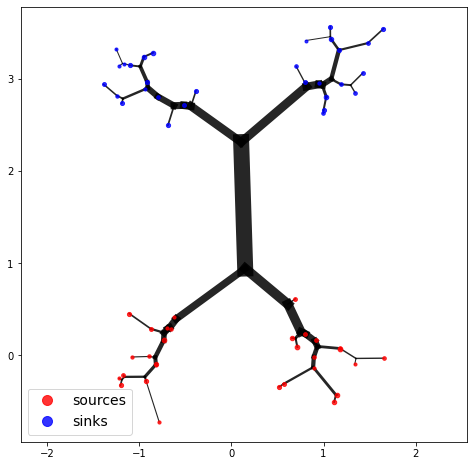


 al= 0.5
final result, after 582 iterations.


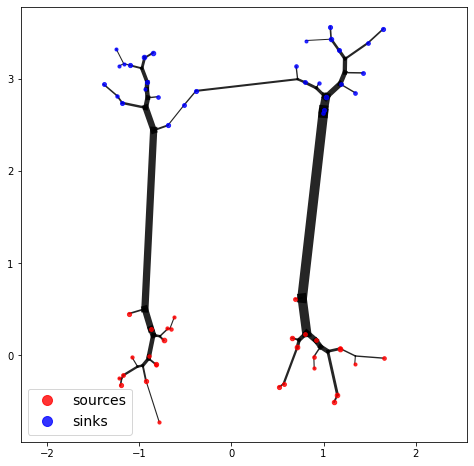


 al= 0.7
final result, after 510 iterations.


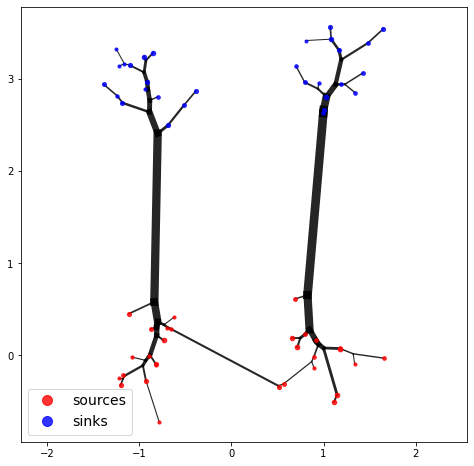


 al= 1.0


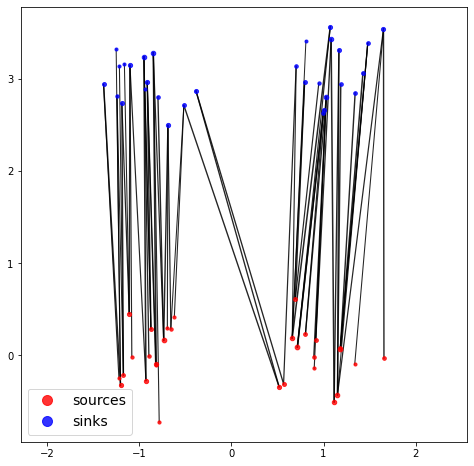

In [3]:
#2-to-2 clusters experiment:
n_sources = 30
n_sinks = 30
centers = np.array([
    [-1,0],
    [1,0],
    [-1,3],
    [1,3]
])    

coords_sources = np.vstack((np.random.normal(size=(int(n_sources/2), 2), scale=0.3) + centers[0], np.random.normal(size=(int(n_sources/2), 2), scale=0.3) + centers[1]))
coords_sinks = np.vstack((np.random.normal(size=(int(n_sinks/2), 2), scale=0.3) + centers[2], np.random.normal(size=(int(n_sinks/2), 2), scale=0.3) + centers[3]))

al_arr = np.array([0.0001, 0.3, 0.5, 0.7, 1])

bot_problem_dict = {}
bot_problem_dict["coords_sources"] = coords_sources
bot_problem_dict["coords_sinks"] = coords_sinks
bot_problem_dict["supply_arr"] = np.random.random(len(coords_sources))
bot_problem_dict["supply_arr"] /= np.sum(bot_problem_dict["supply_arr"])
bot_problem_dict["demand_arr"] = np.random.random(len(coords_sinks))
bot_problem_dict["demand_arr"] /= np.sum(bot_problem_dict["demand_arr"])

supply_arr = bot_problem_dict["supply_arr"]
demand_arr = bot_problem_dict["demand_arr"]

for al in al_arr:
    print("\n al=", al)
    bot_problem_dict["al"] = al    
    
    if al > 0.999:
        al = 1
        int_prior_topo = interpolated_prior(bot_problem_dict, beta = 1-al)
        cost, coords_real = iterative_bot_solver(int_prior_topo, supply_arr, demand_arr, coords_sources, coords_sinks, al,
                                                     relative_improvement_threshold=1e-6, min_iterations=-1, max_iterations=1000,
                                                     plot=False, title="", fov=None, save=False, save_name="img")

        coords_arr = np.vstack((coords_sources, coords_sinks))
        num_bps = nx.number_of_nodes(int_prior_topo) - len(supply_arr) -len(demand_arr)
        coords_arr = np.vstack((coords_arr, np.zeros((num_bps, 2)) ))
        for bp in int_prior_topo.nodes():
            if bp >= 0:
                continue
            for neighbour in nx.neighbors(int_prior_topo, bp):
                if neighbour >= 0:
                    coords_arr[bp] = np.copy(coords_arr[neighbour])

        visualise_BOT_solution(int_prior_topo, coords_arr, supply_arr, demand_arr, title="", fov=None, save=False, save_name=f"img100")
    
    else:
        beta = 1 - al
        int_prior_topo = interpolated_prior(bot_problem_dict, beta)
        stress_cost, stress_topo = angular_stress_reduction(int_prior_topo, bot_problem_dict, plot_final=False, plot=False)

        # stress heuristic with MC continued:
        topo = stress_topo.copy()
        cost, coords_iter = iterative_bot_solver(topo, supply_arr, demand_arr, coords_sources, coords_sinks, al,
                                                 relative_improvement_threshold=1e-9, min_iterations=-1,
                                                 max_iterations=10000,
                                                 plot=False, title="", fov=None, save=False, save_name="img")
        keep_going = True
        iteration = 0
        T = 0
        sample_edge_list = list(topo.edges())
        while keep_going and iteration < 60000:
            iteration += 1
            topo, sample_edge_list, cost, coords_iter, accepted = monte_carlo_step(topo, sample_edge_list, cost,
                                                                                   coords_iter, bot_problem_dict,
                                                                                   temperature=T)
            # check if converged:
            if len(sample_edge_list) == 0:
                # this means that we have stuck with one topology for an entire run through.
                keep_going = False

        print(f"final result, after {iteration} iterations.")

        cost, coords_iter = iterative_bot_solver(topo, supply_arr, demand_arr, coords_sources, coords_sinks, al,
                                                 relative_improvement_threshold=1e-6, min_iterations=-1,
                                                 max_iterations=2000,
                                                 plot=True, title="", fov=None, save=False, save_name="img")

Sichel Experiment:

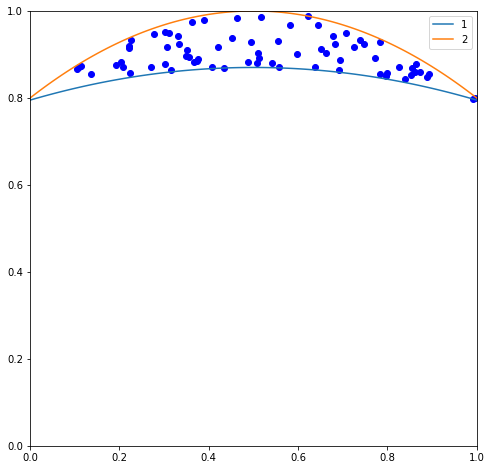

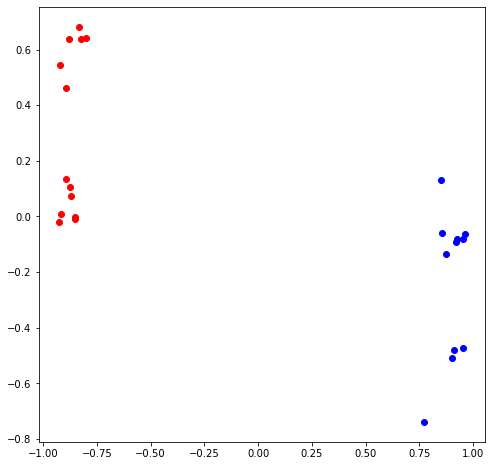

In [4]:
x = np.random.random((1000,2))

lin = np.linspace(0,1,100)

mask1 = x[:,1] < -0.8*(x[:,0] - 0.5)**2  + 1
mask2 = x[:,1] > -0.3*(x[:,0] - 0.5)**2 + 1 - 0.13

mask = mask1 * mask2

sichel1 = x[mask]

plt.figure(figsize=(8,8))
    
for point in sichel1:
    plt.plot(point[0], point[1], "bo")
    
plt.plot(lin, -0.3*(lin - 0.5)**2 + 1 - 0.13, label="1")
plt.plot(lin, -0.8*(lin - 0.5)**2  + 1, label="2")
plt.xlim(0,1)
plt.ylim(0,1)
#plt.axis("equal")
plt.legend()
plt.show()


N = 100

x = np.random.random((N,2))

lin = np.linspace(0,1,100)

mask1 = x[:,1] < -0.8*(x[:,0] - 0.5)**2  + 1
mask2 = x[:,1] > -0.3*(x[:,0] - 0.5)**2 + 1 - 0.17

mask = mask1 * mask2

sichel1 = x[mask]

x = np.random.random((N,2))

mask1 = x[:,1] < -0.8*(x[:,0] - 0.5)**2  + 1
mask2 = x[:,1] > -0.3*(x[:,0] - 0.5)**2 + 1 - 0.17

mask = mask1 * mask2

sichel2 = x[mask]

phi = 90 * 2 * np.pi / 360
A = np.array([
    [np.cos(phi), np.sin(phi)],
    [-np.sin(phi), np.cos(phi)]
])

for i,point in enumerate(sichel1):
    sichel1[i] = A @ point
    
for i,point in enumerate(sichel2):
    sichel2[i] = -A @ point

sichel2[:,1] -= 0.25 
sichel1[:,1] += 0.25 
    
plt.figure(figsize=(8,8))
    
for point in sichel1:
    plt.plot(point[0], point[1], "bo")

for point in sichel2:
    plt.plot(point[0], point[1], "ro")

    
#plt.xlim(0,1)
#plt.ylim(0,1)
#plt.axis("equal")
#plt.legend()
plt.show()

In [5]:
len(sichel1) + len(sichel2)

24

final result, after 621 iterations.


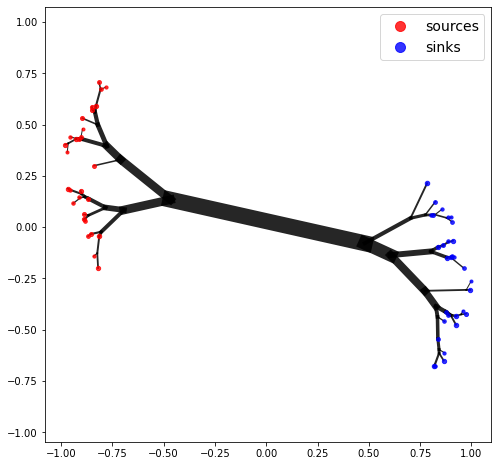

In [74]:
sichel_results_dict = {}

coords_sources = sichel2
coords_sinks = sichel1

al_arr = np.array([0.0001, 0.3, 0.5, 0.7, 1])

bot_problem_dict = {}
bot_problem_dict["coords_sources"] = coords_sources
bot_problem_dict["coords_sinks"] = coords_sinks
bot_problem_dict["supply_arr"] = np.random.random(len(coords_sources))
bot_problem_dict["supply_arr"] /= np.sum(bot_problem_dict["supply_arr"])
bot_problem_dict["demand_arr"] = np.random.random(len(coords_sinks))
bot_problem_dict["demand_arr"] /= np.sum(bot_problem_dict["demand_arr"])

for al in al_arr:
    bot_problem_dict["al"] = 0.85

    al = bot_problem_dict["al"]
    supply_arr = bot_problem_dict["supply_arr"]
    demand_arr = bot_problem_dict["demand_arr"]
    
    if al > 0.999:
        al = bot_problem_dict["al"]
        coords_sources = bot_problem_dict["coords_sources"]
        coords_sinks = bot_problem_dict["coords_sinks"]
        supply_arr = bot_problem_dict["supply_arr"]
        demand_arr = bot_problem_dict["demand_arr"]
        al = 1

        int_prior_topo = interpolated_prior(bot_problem_dict, beta = 1-al)
        cost, coords_real = iterative_bot_solver(int_prior_topo, supply_arr, demand_arr, coords_sources, coords_sinks, al,
                                                     relative_improvement_threshold=1e-6, min_iterations=-1, max_iterations=1000,
                                                     plot=False, title="", fov=None, save=False, save_name="img")

        coords_arr = np.vstack((coords_sources, coords_sinks))
        num_bps = nx.number_of_nodes(int_prior_topo) - len(supply_arr) -len(demand_arr)
        coords_arr = np.vstack((coords_arr, np.zeros((num_bps, 2)) ))
        for bp in int_prior_topo.nodes():
            if bp >= 0:
                continue
            for neighbour in nx.neighbors(int_prior_topo, bp):
                if neighbour >= 0:
                    coords_arr[bp] = np.copy(coords_arr[neighbour])

        visualise_BOT_solution(int_prior_topo, coords_arr, supply_arr, demand_arr, title="", fov=None, save=False, save_name=f"img100")
    
    else:
        beta = 1 - bot_problem_dict["al"]
        int_prior_topo = interpolated_prior(bot_problem_dict, beta)
        stress_cost, stress_topo = angular_stress_reduction(int_prior_topo, bot_problem_dict, plot_final=False, plot=False)

        # stress heuristic with MC continued:
        topo = stress_topo.copy()
        cost, coords_iter = iterative_bot_solver(topo, supply_arr, demand_arr, coords_sources, coords_sinks, al,
                                                 relative_improvement_threshold=1e-9, min_iterations=-1,
                                                 max_iterations=10000,
                                                 plot=False, title="", fov=None, save=False, save_name="img")
        keep_going = True
        iteration = 0
        T = 0
        sample_edge_list = list(topo.edges())
        while keep_going and iteration < 60000:
            iteration += 1
            topo, sample_edge_list, cost, coords_iter, accepted = monte_carlo_step(topo, sample_edge_list, cost,
                                                                                   coords_iter, bot_problem_dict,
                                                                                   temperature=T)
            # check if converged:
            if len(sample_edge_list) == 0:
                # this means that we have stuck with one topology for an entire run through.
                keep_going = False

        print(f"final result, after {iteration} iterations.")

        cost, coords_iter = iterative_bot_solver(topo, supply_arr, demand_arr, coords_sources, coords_sinks, al,
                                                 relative_improvement_threshold=1e-6, min_iterations=-1,
                                                 max_iterations=2000,
                                                 plot=True, title="", fov=None, save=False, save_name="img")
        
    

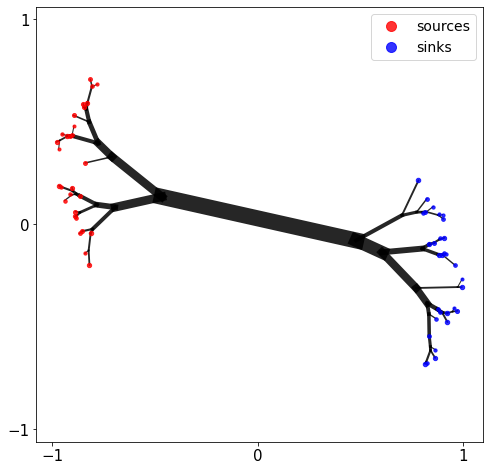

In [77]:
cost, coords_iter = iterative_bot_solver(topo, supply_arr, demand_arr, coords_sources, coords_sinks, al,
                                         relative_improvement_threshold=1e-9, min_iterations=-1,
                                         max_iterations=10000,
                                         plot=True, title="", fov=None, save=True, save_name="img085")

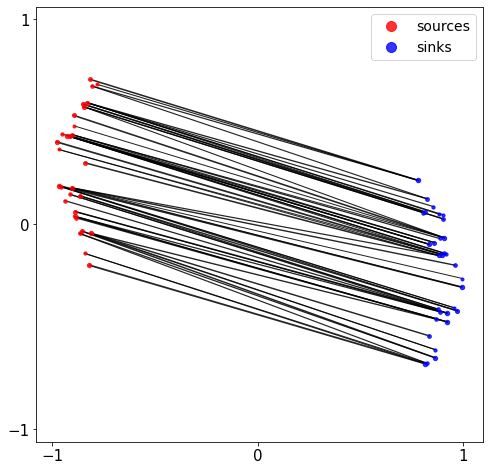

In [78]:
#OT solution specificaly for alpha = 1:

al = bot_problem_dict["al"]
coords_sources = bot_problem_dict["coords_sources"]
coords_sinks = bot_problem_dict["coords_sinks"]
supply_arr = bot_problem_dict["supply_arr"]
demand_arr = bot_problem_dict["demand_arr"]
al = 1

int_prior_topo = interpolated_prior(bot_problem_dict, beta = 1-al)
cost, coords_real = iterative_bot_solver(int_prior_topo, supply_arr, demand_arr, coords_sources, coords_sinks, al,
                                             relative_improvement_threshold=1e-6, min_iterations=-1, max_iterations=1000,
                                             plot=False, title="", fov=None, save=False, save_name="img")

coords_arr = np.vstack((coords_sources, coords_sinks))
num_bps = nx.number_of_nodes(int_prior_topo) - len(supply_arr) -len(demand_arr)
coords_arr = np.vstack((coords_arr, np.zeros((num_bps, 2)) ))
for bp in int_prior_topo.nodes():
    if bp >= 0:
        continue
    for neighbour in nx.neighbors(int_prior_topo, bp):
        if neighbour >= 0:
            coords_arr[bp] = np.copy(coords_arr[neighbour])

visualise_BOT_solution(int_prior_topo, coords_arr, supply_arr, demand_arr, title="", fov=None, save=True, save_name=f"img100")

In [ ]:
n_sources = 30
n_sinks = 30
bot_problem_dict = {}
coords_sources = np.zeros((n_sources, 2))
coords_sources[:,1] = np.linspace(0,1,n_sources)

coords_sinks = np.zeros((n_sinks, 2))
coords_sinks[:,1] = np.linspace(0,1,n_sinks)
coords_sinks[:,0] = 0.3

bot_problem_dict["coords_sources"] = coords_sources
bot_problem_dict["coords_sinks"] = coords_sinks
bot_problem_dict["supply_arr"] = np.ones(n_sources) / n_sources
bot_problem_dict["demand_arr"] = np.ones(n_sinks) / n_sinks
bot_problem_dict["al"] = 0.5

beta = 1 - bot_problem_dict["al"]
int_prior_topo = interpolated_prior(bot_problem_dict, beta)
stress_cost, _ = angular_stress_reduction(int_prior_topo, bot_problem_dict, plot_final=True, plot=False)


al= 0.04062708064371212


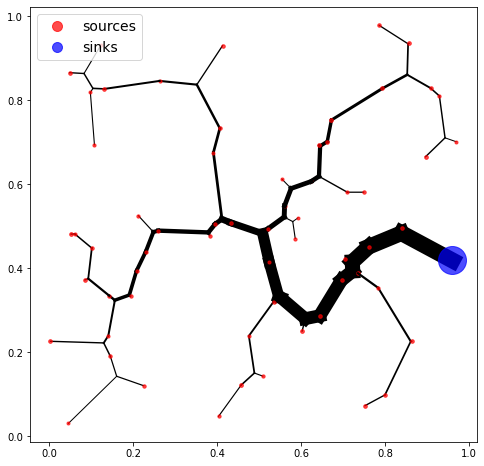

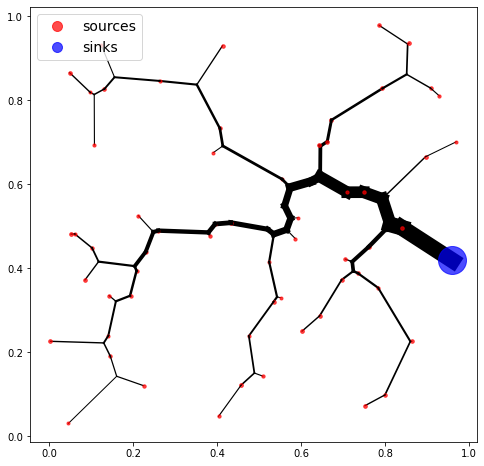

cost stress=4.575310575574734, cost increm=4.641766192266419 


al= 0.5890892060356141


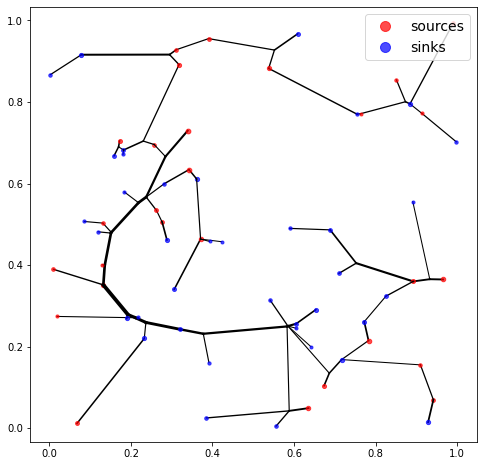

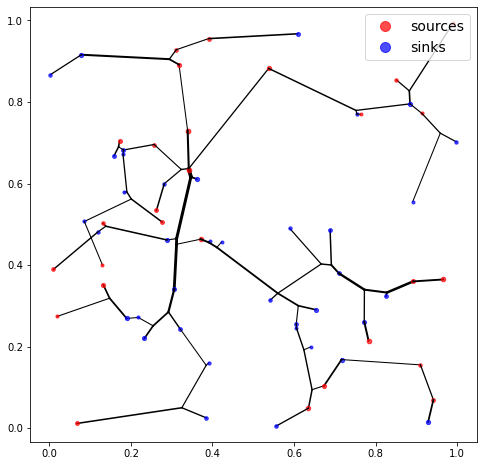

cost stress=0.8495619847035027, cost increm=0.8332222808072579 


al= 0.25495587193477154


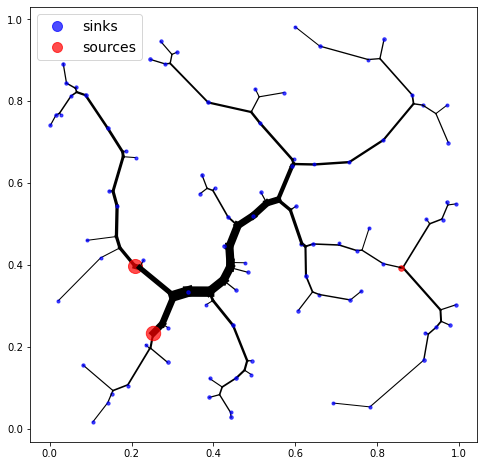

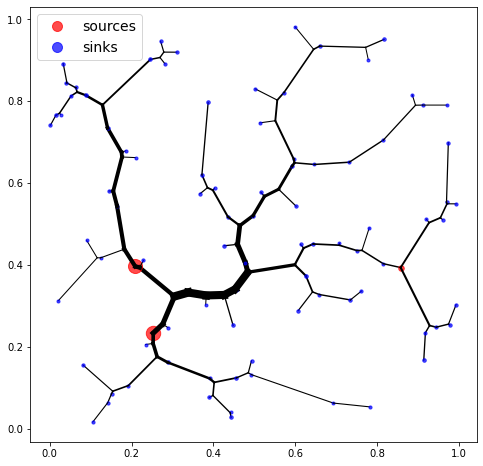

cost stress=2.8781348869460244, cost increm=2.86929350064551 


al= 0.6402296405248253


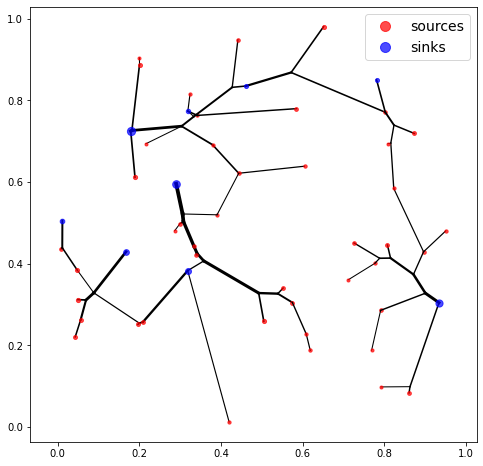

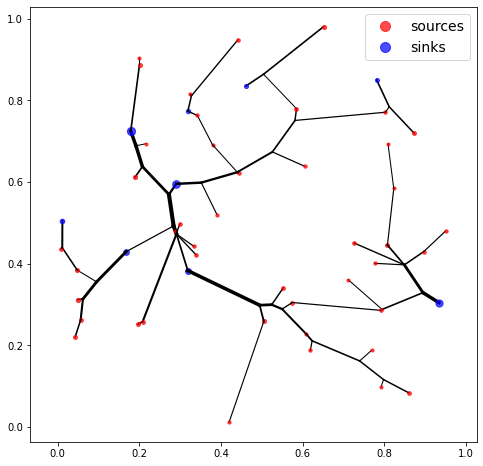

cost stress=0.7179841650467746, cost increm=0.7320982828292872 


al= 0.4942627689572051


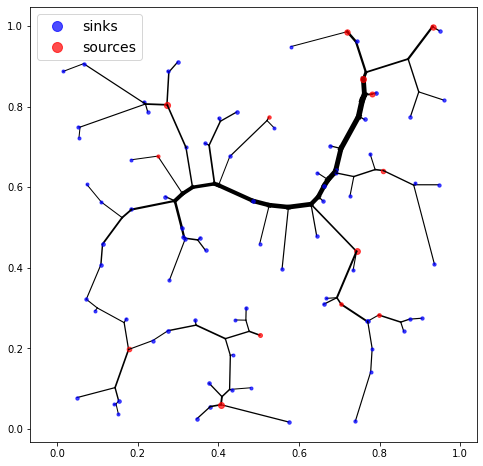

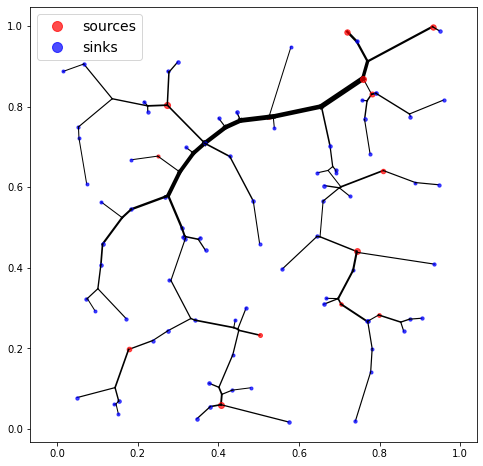

cost stress=1.293549585072853, cost increm=1.2419729942941862 


al= 0.5088181882385826


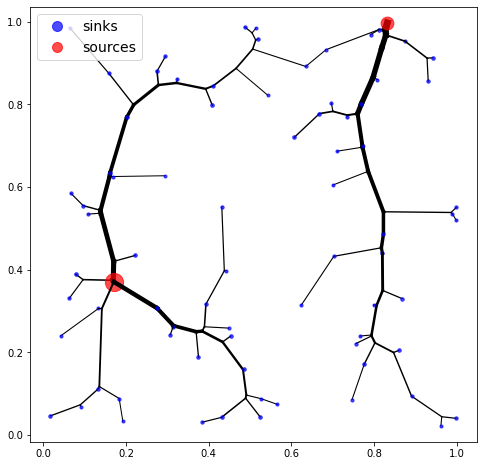

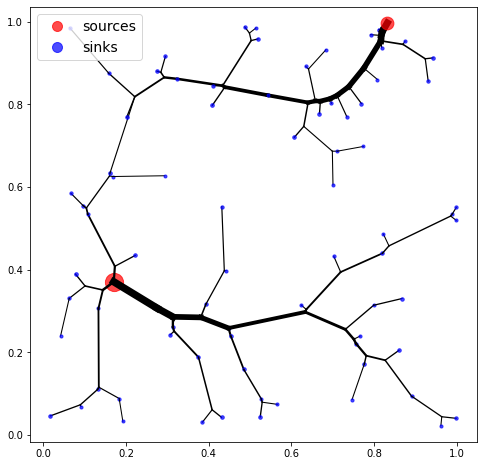

cost stress=1.37077091887195, cost increm=1.3762511815514646 


al= 0.8302027023625694


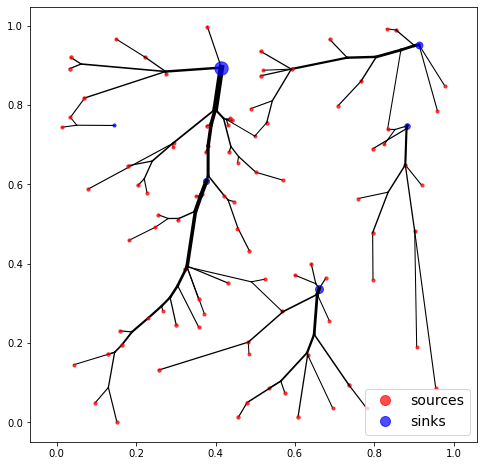

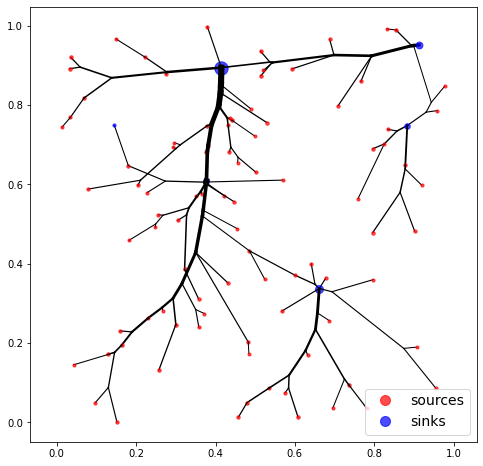

cost stress=0.5251971597253534, cost increm=0.5470039816608117 


al= 0.06825940417762721


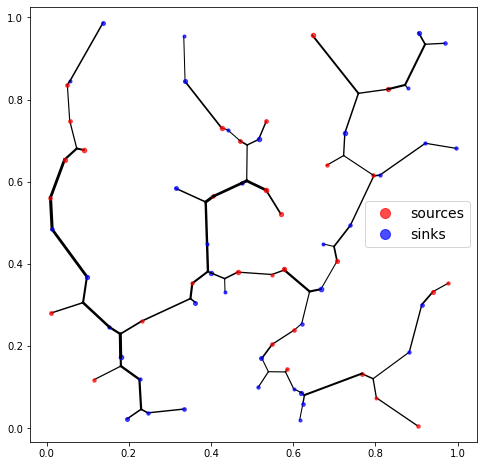

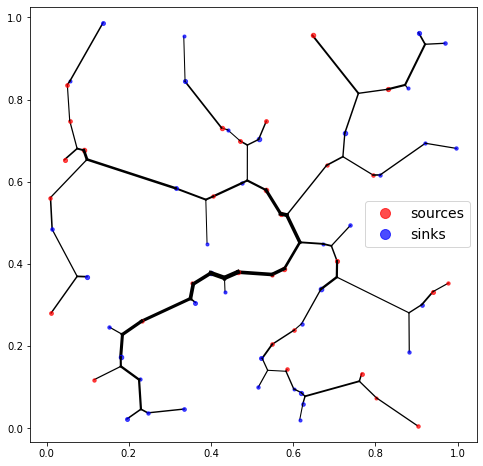

cost stress=4.370720742095827, cost increm=4.6475311270485715 


al= 0.0851248943074927


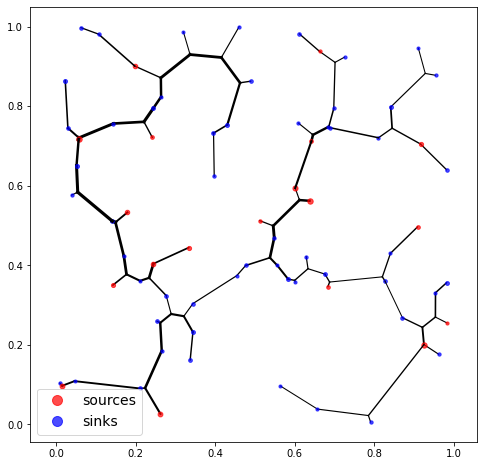

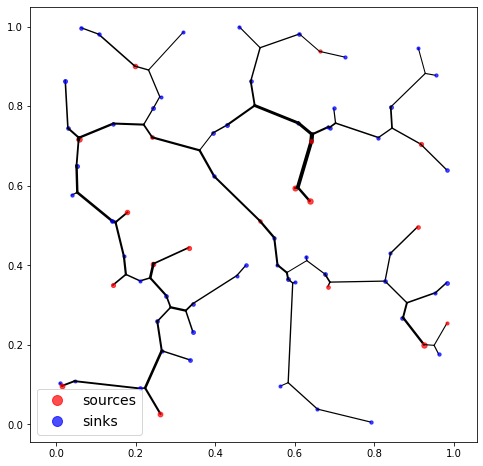

cost stress=4.516683957859202, cost increm=4.645800605264727 


al= 0.39543871140670783


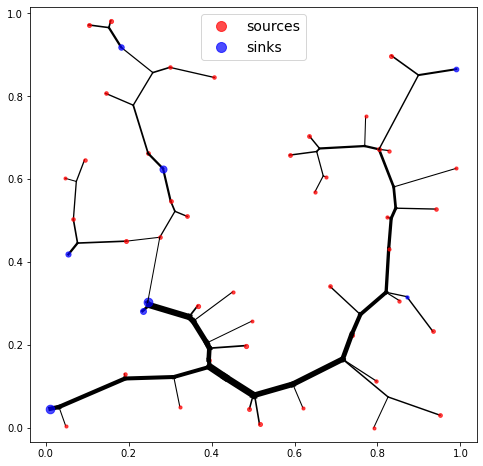

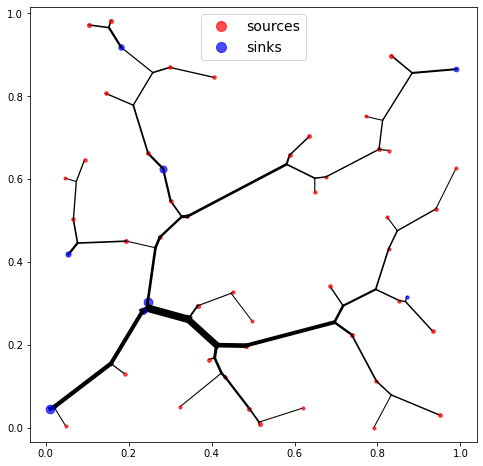

cost stress=1.7839875627411164, cost increm=1.7226106345234318 


al= 0.7890740968192725


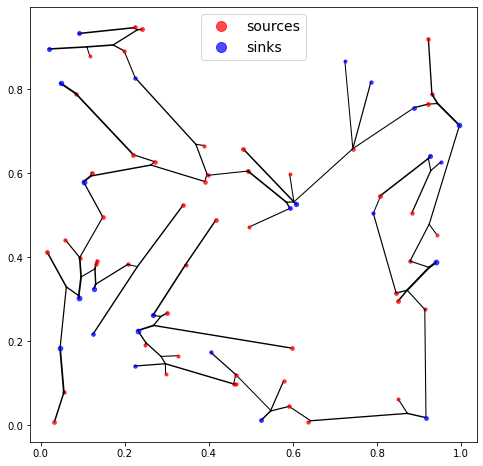

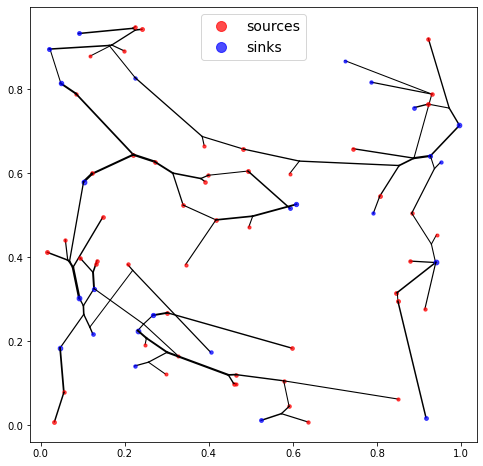

cost stress=0.36713802954424773, cost increm=0.4202745718756772 


al= 0.23842802850080624


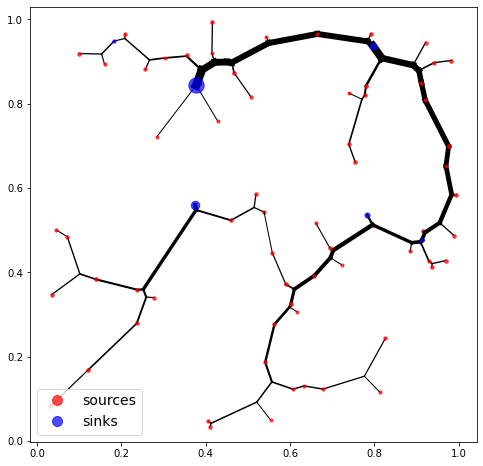

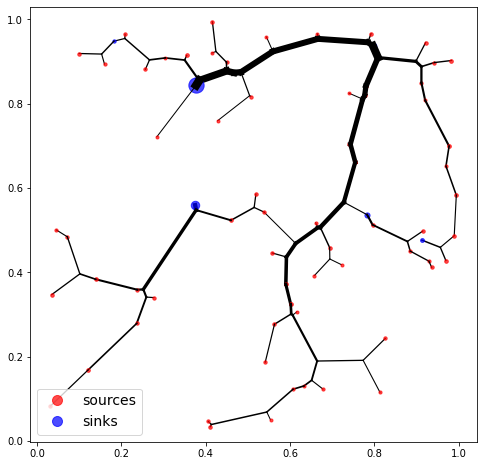

cost stress=2.7161209737159018, cost increm=2.7648218153373643 


al= 0.19718890711998904


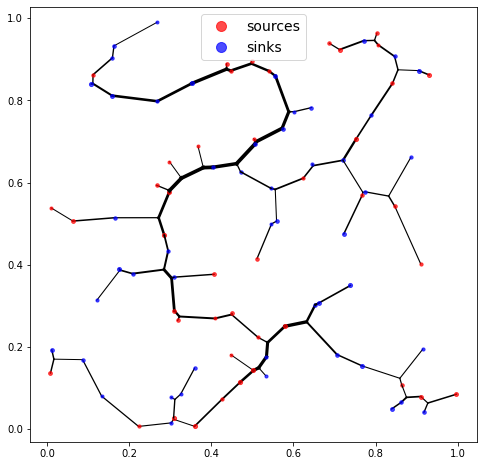

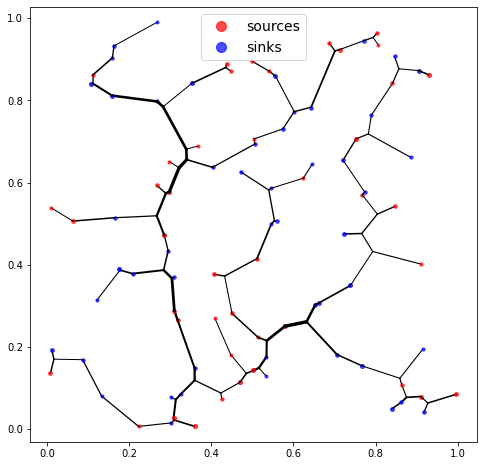

cost stress=3.08870779307858, cost increm=2.9947204249141297 


al= 0.3513051702947345


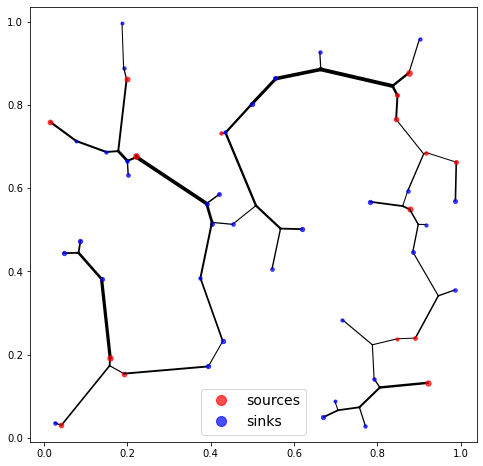

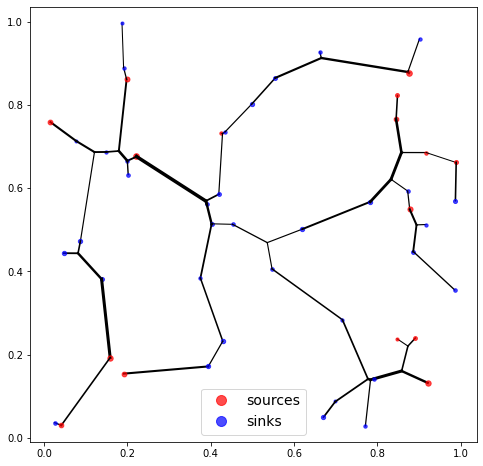

cost stress=1.685806399836011, cost increm=1.7448426978995728 


al= 0.0030366500019683995


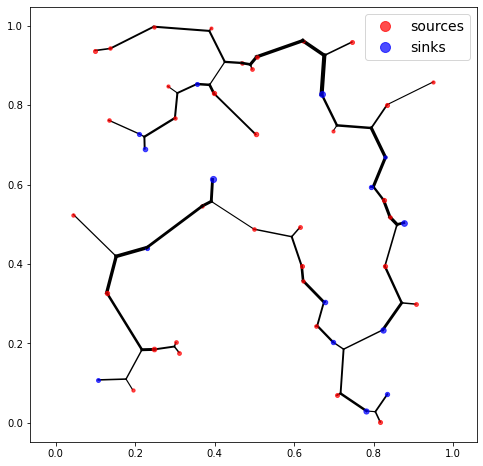

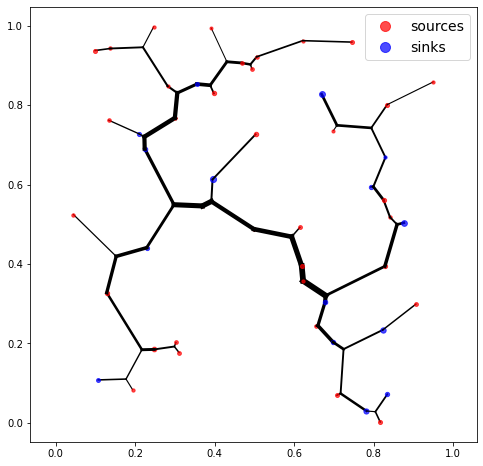

cost stress=4.55084027139102, cost increm=4.677506366303845 


al= 0.8692004936186445


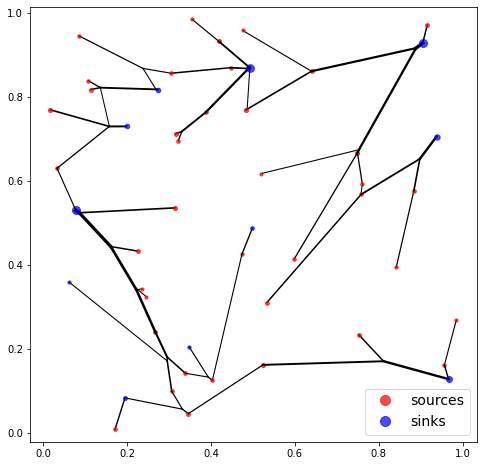

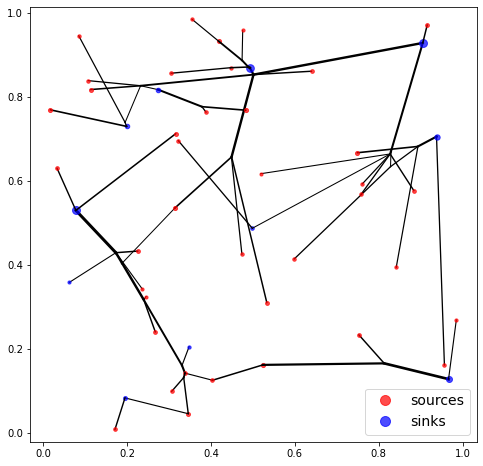

cost stress=0.4001930863938996, cost increm=0.4996725469771934 


al= 0.5021243924951437


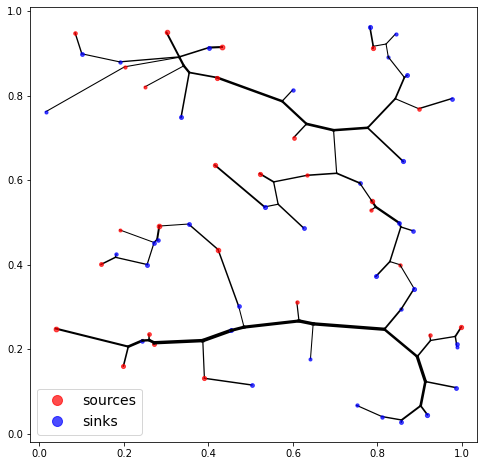

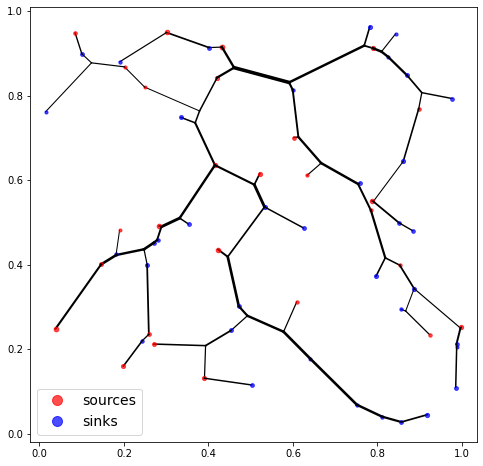

cost stress=1.1867293695381242, cost increm=1.3018982666647625 


al= 0.3141727445845134


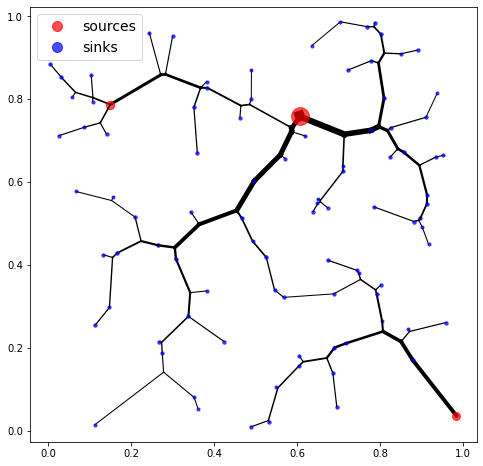

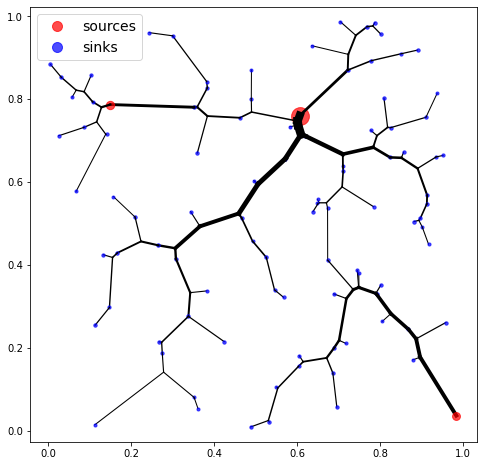

cost stress=2.438546618824983, cost increm=2.469901986318893 


al= 0.21511406907864383


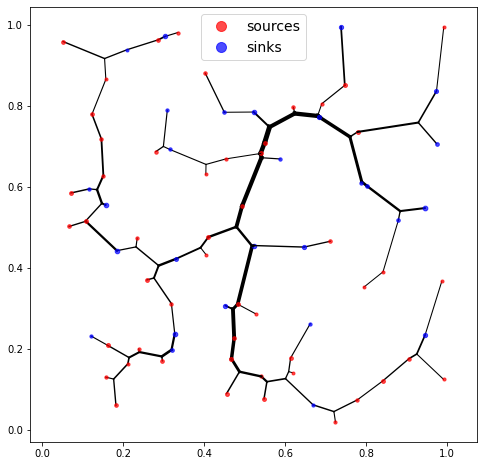

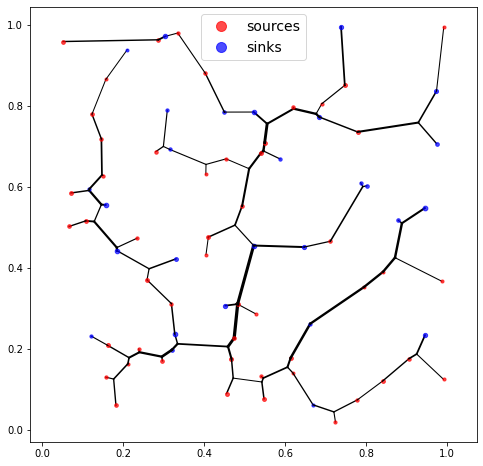

cost stress=2.9617484139330994, cost increm=2.997000457293826 


al= 0.049734015654439134


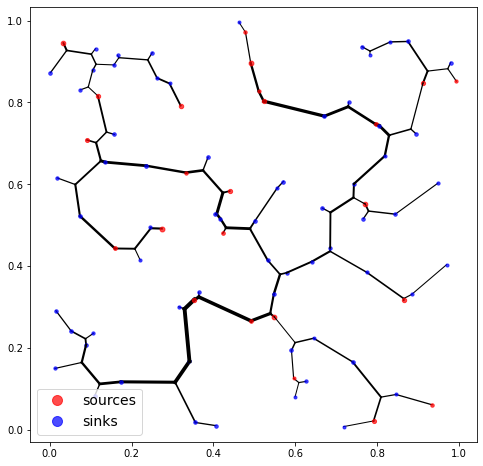

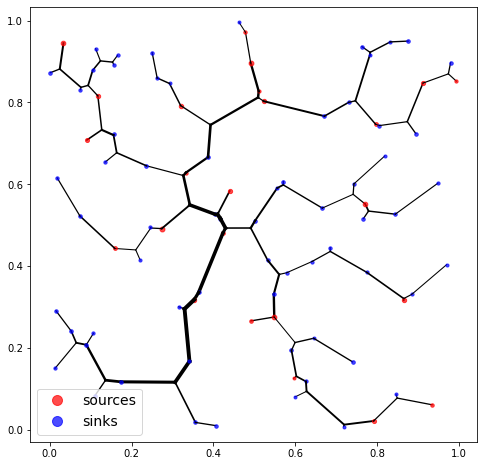

cost stress=5.471216440857845, cost increm=5.645820645303995 


al= 0.44834036044602343


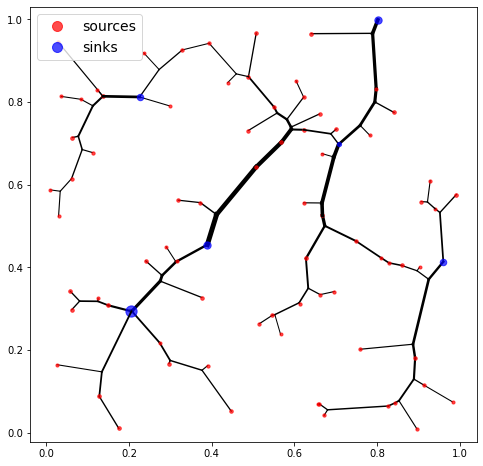

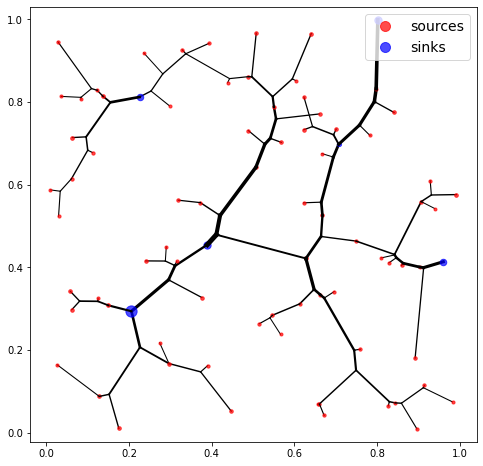

cost stress=1.6060912603185131, cost increm=1.6799480089402614 


al= 0.8271541283884065


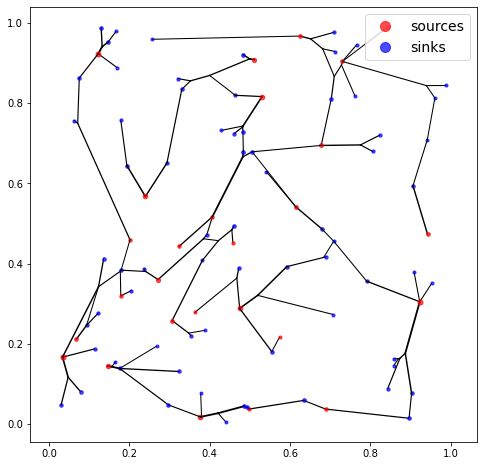

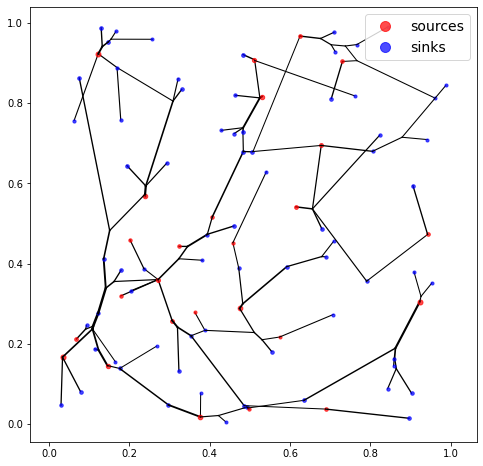

cost stress=0.27629559312230434, cost increm=0.3711082714888666 


al= 0.28013042430500934


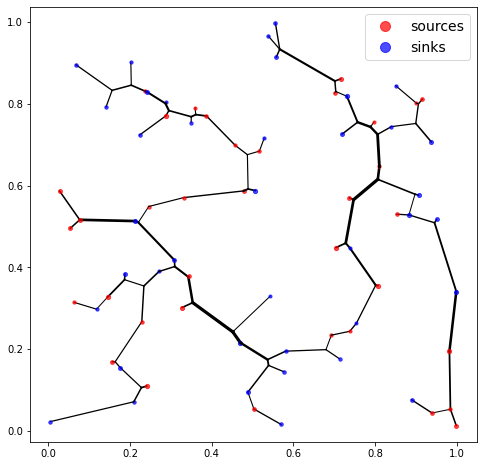

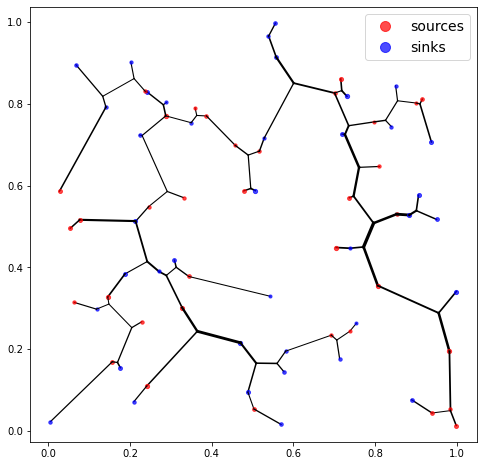

cost stress=2.259406056156453, cost increm=2.254056594506266 


al= 0.9305611568365686


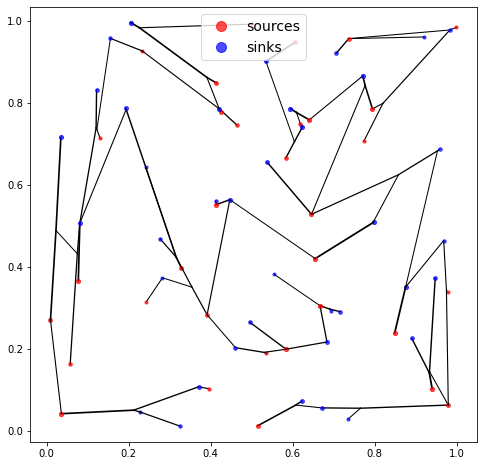

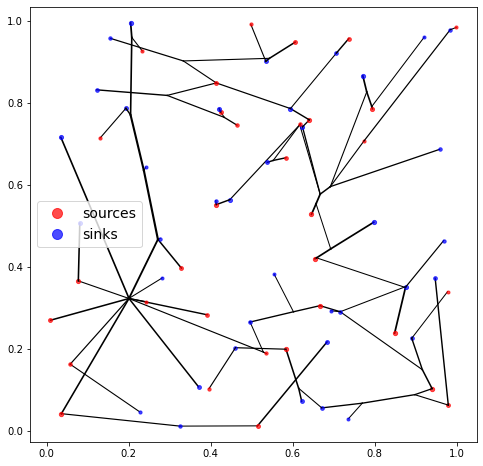

cost stress=0.23457600077369384, cost increm=0.30520509269080576 


al= 0.36238962641786077


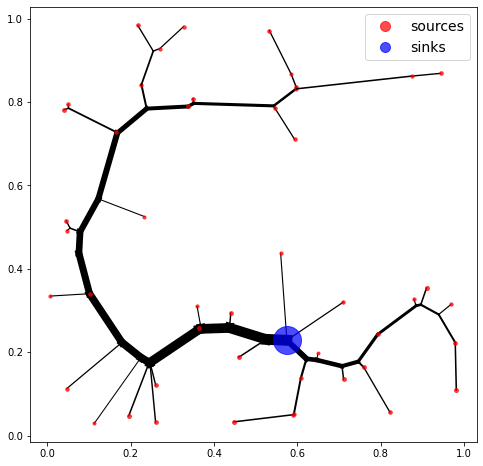

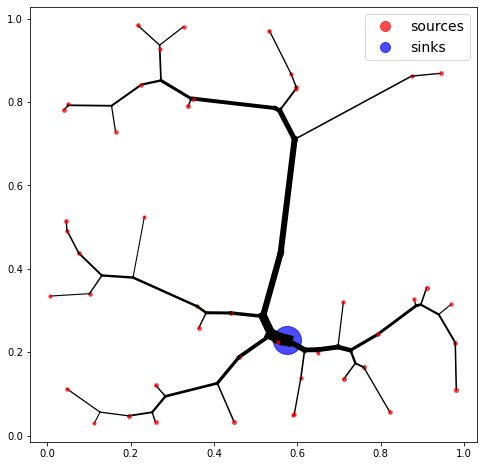

cost stress=2.0954185235700127, cost increm=1.958067044787372 


al= 0.713683237189718


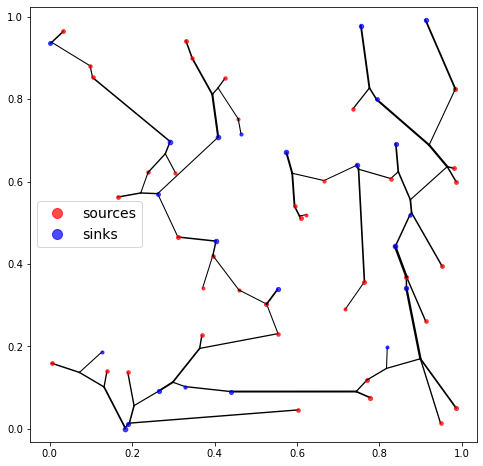

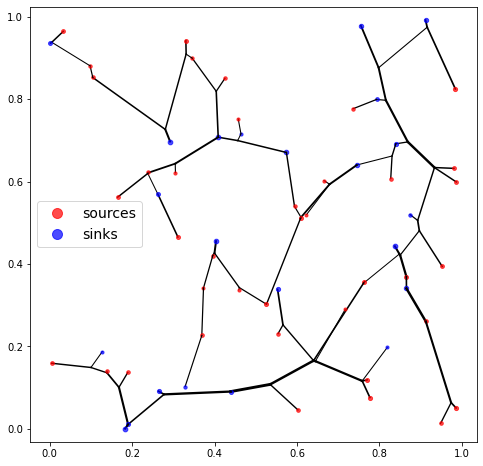

cost stress=0.5718018324943684, cost increm=0.6356933884956678 


al= 0.26027956911195593


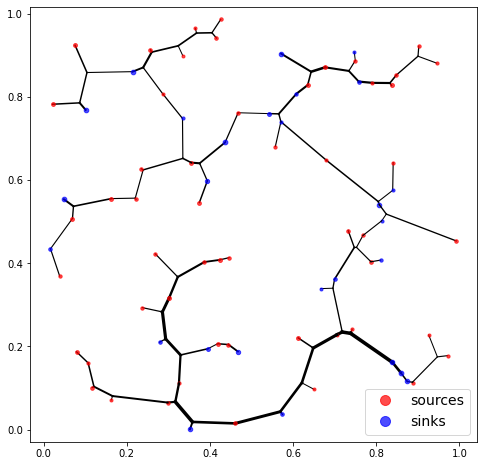

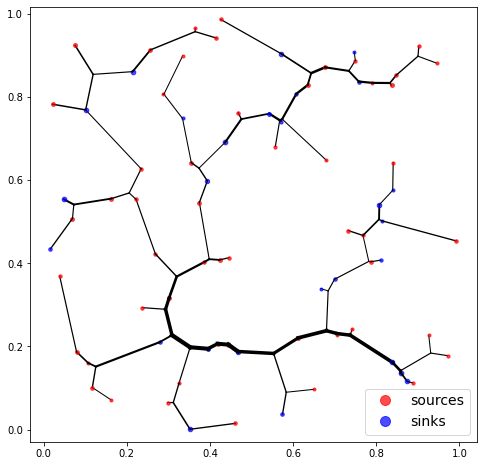

cost stress=2.4104239065845126, cost increm=2.4403377629012564 


al= 0.42960256848808


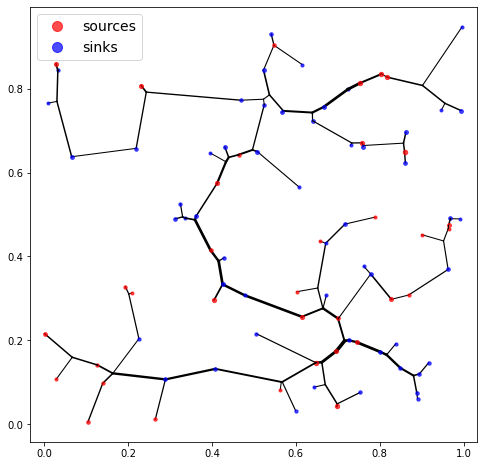

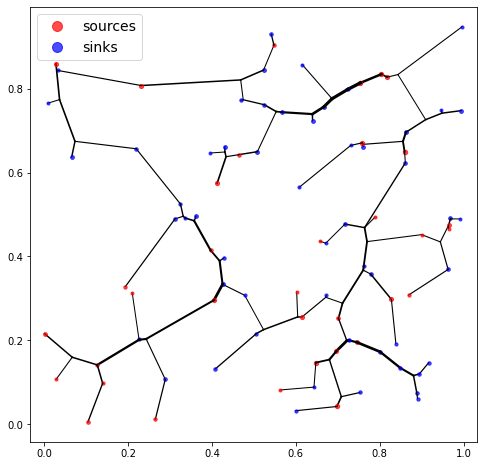

cost stress=1.39509033126913, cost increm=1.3522307597650656 


al= 0.8176062503852606


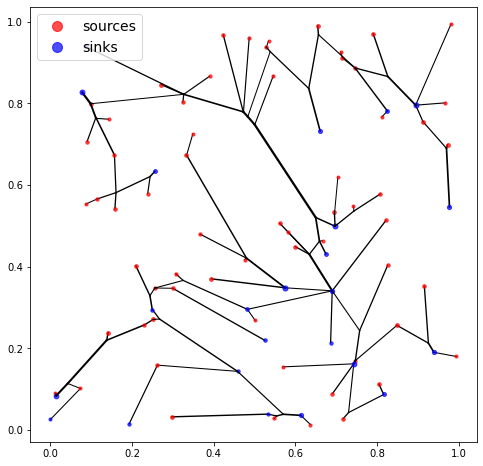

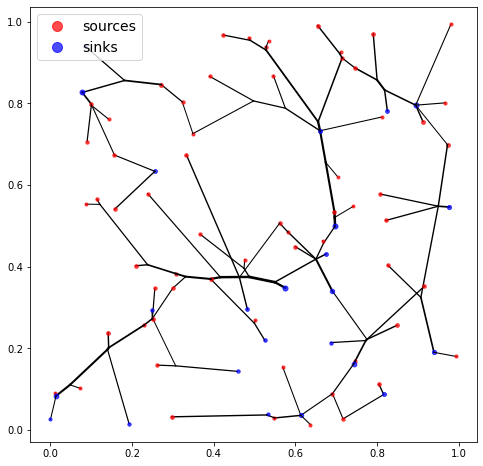

cost stress=0.42951961063101635, cost increm=0.44690944686151063 


al= 0.39444674678609004


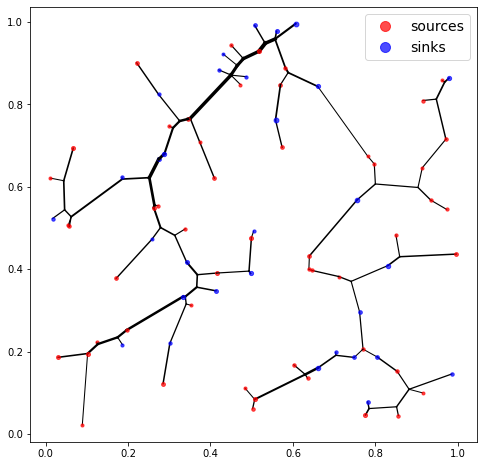

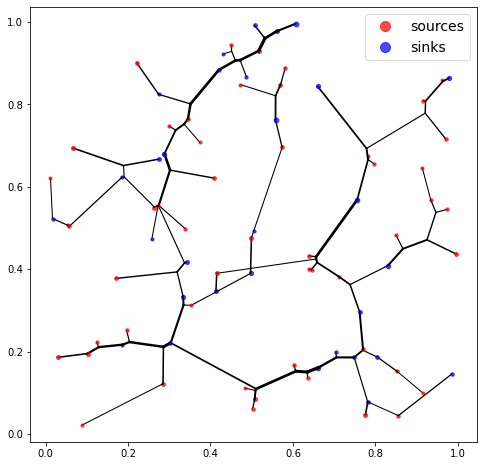

cost stress=1.565610779326516, cost increm=1.7317066368137901 




In [42]:
num_problems = 30
for k in range(num_problems):

    # generate a random problem:
    num_terminals = np.random.randint(50,100)
    num_sources = np.random.randint(1, num_terminals)
    num_sinks = num_terminals - num_sources
    bot_problem_dict = generate_random_bot_problem(num_sources, num_sinks, normalised_to=1, dim=2,
                                                   max_length=1.)

    # stress reduction heursitic:
    al = bot_problem_dict["al"]
    print("al=", al)
    coords_sources = bot_problem_dict["coords_sources"]
    coords_sinks = bot_problem_dict["coords_sinks"]
    supply_arr = bot_problem_dict["supply_arr"]
    demand_arr = bot_problem_dict["demand_arr"]
    beta = 1 - al
    int_prior_topo = interpolated_prior(bot_problem_dict, beta)
    stress_cost, _ = angular_stress_reduction(int_prior_topo, bot_problem_dict, plot_final=True, plot=False)
    
    m = 5
    growth_cost, growth_topo = incremental_growth_heuristic(bot_problem_dict, m, plot=False, final_plot=True)
    
    print(f"cost stress={stress_cost}, cost increm={growth_cost} \n\n")

degree_excess= 0


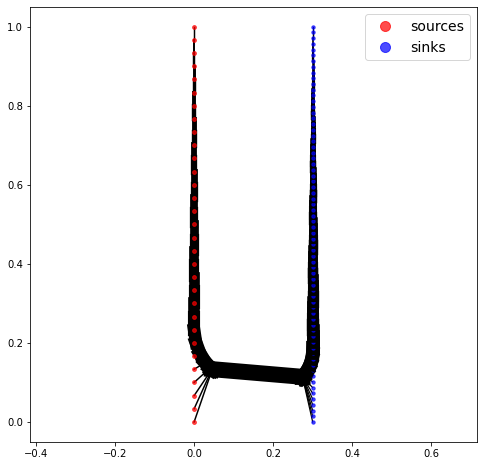

In [47]:
# points on two lines:
n_sources = 31
n_sinks = 70
bot_problem_dict = {}
coords_sources = np.zeros((n_sources, 2))
coords_sources[:,1] = np.linspace(0,1,n_sources)

coords_sinks = np.zeros((n_sinks, 2))
coords_sinks[:,1] = np.linspace(0,1,n_sinks)
coords_sinks[:,0] = 0.3

bot_problem_dict["coords_sources"] = coords_sources
bot_problem_dict["coords_sinks"] = coords_sinks
bot_problem_dict["supply_arr"] = np.ones(n_sources) / n_sources
bot_problem_dict["demand_arr"] = np.ones(n_sinks) / n_sinks
bot_problem_dict["al"] = 0.5

beta = 1 - bot_problem_dict["al"]
int_prior_topo = interpolated_prior(bot_problem_dict, beta)
stress_cost, _ = angular_stress_reduction(int_prior_topo, bot_problem_dict, plot_final=True, plot=False)

#m = 5
#growth_cost, growth_topo = incremental_growth_heuristic(bot_problem_dict, m, plot=False, final_plot=True)

degree_excess= 30


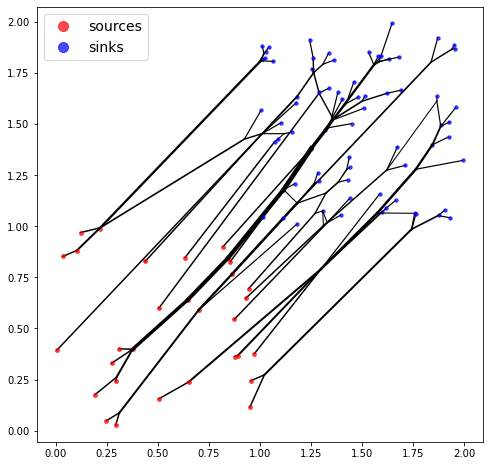

In [46]:
# two point clouds:
n_sources = 31
n_sinks = 70
bot_problem_dict = {}
coords_sources = np.random.random((n_sources, 2))
coords_sinks = np.random.random((n_sinks, 2)) + 1

bot_problem_dict["coords_sources"] = coords_sources
bot_problem_dict["coords_sinks"] = coords_sinks
bot_problem_dict["supply_arr"] = np.ones(n_sources) / n_sources
bot_problem_dict["demand_arr"] = np.ones(n_sinks) / n_sinks
bot_problem_dict["al"] = 0.9

beta = 1 - bot_problem_dict["al"]
int_prior_topo = interpolated_prior(bot_problem_dict, beta)
stress_cost, _ = angular_stress_reduction(int_prior_topo, bot_problem_dict, plot_final=True, plot=False)

#m = 5
#growth_cost, growth_topo = incremental_growth_heuristic(bot_problem_dict, m, plot=False, final_plot=True)

In [15]:
growth_cost

1.485128476914294

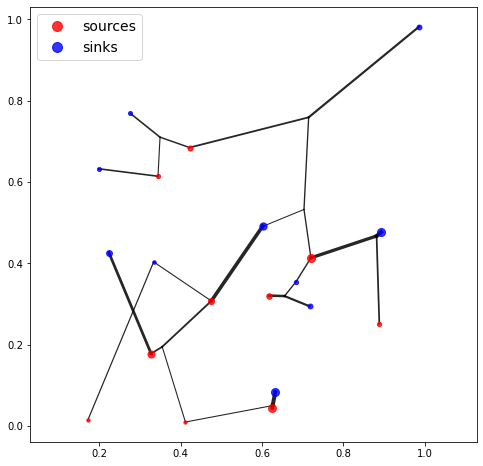

In [5]:
# test incremental growth heuristic:

# generate a random problem:
num_terminals = 20
num_sources = np.random.randint(1, num_terminals)
num_sinks = num_terminals - num_sources
bot_problem_dict = generate_random_bot_problem(num_sources, num_sinks, normalised_to=1, dim=2,
                                               max_length=1.)

# stress reduction heursitic:
al = bot_problem_dict["al"]
coords_sources = bot_problem_dict["coords_sources"]
coords_sinks = bot_problem_dict["coords_sinks"]
supply_arr = bot_problem_dict["supply_arr"]
demand_arr = bot_problem_dict["demand_arr"]

m = 5
growth_cost, growth_topo = incremental_growth_heuristic(bot_problem_dict, m, plot=False, final_plot=True)